In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
# Importazioni per sistema e dati
import os
import logging
import sys
import pandas as pd
import numpy as np
import torch
from typing import Dict, List
import matplotlib.pyplot as plt
import seaborn as sns

# Importazioni da Scikit-learn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Importazioni da Hugging Face
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EvalPrediction,
    EarlyStoppingCallback
)

# Importazioni dal tuo file di configurazione
sys.path.append(os.path.abspath(os.path.join('..')))
import config
from config import (
    PROCESSED_DATA_DIR, TRAIN_FILE, VAL_FILE, TEST_FILE,
    TEXT_COLUMN, PERSON_COUPLE_COLUMN
)

# Definizioni principali
MODEL_NAME = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] - %(message)s", stream=sys.stdout)
merged = ""

In [3]:
# file path for merged train and test data
#TRAIN_FILE, TEST_FILE = "train_merged.json", "test_merged.json"
#merged = "merged"

In [ ]:
def format_conversation(dialogue_list: List[Dict[str, str]]) -> str:
    """
    Formats a list of dialogue entries into a single string, 
    assigning speakers as [A] and [B].
    """
    formatted_texts = []
    speaker_map = {}
    for entry in dialogue_list:
        speaker_name = entry.get('speaker', 'Unknown')
        text = entry.get('text', '')
        if speaker_name not in speaker_map:
            speaker_map[speaker_name] = '[A]' if not speaker_map else '[B]'
        
        if speaker_name in speaker_map:
            placeholder = speaker_map[speaker_name]
            formatted_texts.append(f'{placeholder}: "{text}"')
            
    return "\n".join(formatted_texts)


In [ ]:
# Merge file paths
all_files = [
    os.path.join(PROCESSED_DATA_DIR, TRAIN_FILE),
    os.path.join(PROCESSED_DATA_DIR, VAL_FILE),
    os.path.join(PROCESSED_DATA_DIR, TEST_FILE)
]

# Load and merge all data into a single DataFrame
full_df = pd.concat([pd.read_json(f) for f in all_files], ignore_index=True)
full_df = full_df.drop_duplicates(subset='conversation_id').reset_index(drop=True)
logging.info(f"Loaded {len(full_df)} unique total records.")

# Rename columns and format text
full_df = full_df.rename(columns={'dialogue': TEXT_COLUMN, 'person_couple': PERSON_COUPLE_COLUMN})
full_df[TEXT_COLUMN] = full_df[TEXT_COLUMN].apply(format_conversation)

# Create numerical labels
unique_labels = sorted(full_df[PERSON_COUPLE_COLUMN].unique().tolist())
id2label = {i: label for i, label in enumerate(unique_labels)}
label2id = {label: i for i, label in enumerate(unique_labels)}
full_df['label'] = full_df[PERSON_COUPLE_COLUMN].map(label2id)

# Split the data (70% training, 15% validation, 15% test)
train_val_df, test_df = train_test_split(full_df, test_size=0.15, random_state=42, stratify=full_df['label'])
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, random_state=42, stratify=train_val_df['label'])
logging.info(f"Data split into: {len(train_df)} Train, {len(val_df)} Val, {len(test_df)} Test.")

# Create the final DatasetDict
raw_datasets = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(val_df),
    'test': Dataset.from_pandas(test_df)
})
print("Dataset structure:\n", raw_datasets)


2025-08-13 20:34:59,286 [INFO] - Caricati 1000 record unici totali.
2025-08-13 20:34:59,293 [INFO] - Dati suddivisi in: 699 T, 151 V, 150 T.
Struttura del Dataset:
 DatasetDict({
    train: Dataset({
        features: ['conversation_id', 'person_couple', 'name1', 'name2', 'conversation', 'label', '__index_level_0__'],
        num_rows: 699
    })
    validation: Dataset({
        features: ['conversation_id', 'person_couple', 'name1', 'name2', 'conversation', 'label', '__index_level_0__'],
        num_rows: 151
    })
    test: Dataset({
        features: ['conversation_id', 'person_couple', 'name1', 'name2', 'conversation', 'label', '__index_level_0__'],
        num_rows: 150
    })
})


In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_special_tokens({"additional_special_tokens": ["[A]", "[B]"]})
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
logging.info("Special tokens added.")

def tokenize_function(examples):
    """Tokenize the text and include the labels."""
    tokenized_output = tokenizer(
        examples[TEXT_COLUMN],
        padding="max_length",
        truncation=True,
        max_length=512
    )
    tokenized_output["labels"] = examples["label"]
    return tokenized_output

# Remove the original text columns that are no longer needed
columns_to_remove = [col for col in raw_datasets['train'].column_names if col != 'label']

# Apply tokenization
logging.info("Tokenization in progress...")
tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=columns_to_remove
)

2025-08-13 20:35:00,499 [INFO] - Token speciali aggiunti.
2025-08-13 20:35:00,500 [INFO] - Tokenizzazione in corso...


Map:   0%|          | 0/699 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(p: EvalPrediction) -> Dict[str, float]:
    """Compute performance metrics."""
    logits = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    labels = p.label_ids
    preds = np.argmax(logits, axis=-1)
    f1 = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)[2]
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")

class CustomTrainer(Trainer):
    """Custom Trainer to use class weights during training."""
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True 
)
model.resize_token_embeddings(len(tokenizer))

# Training arguments
training_args = TrainingArguments(
    output_dir="./results/toxic_conversation_classifier_final_full" + merged,
    report_to="none", 
    learning_rate=1e-5, 
    per_device_train_batch_size=8,
    num_train_epochs=15, 
    weight_decay=0.05,  
    eval_strategy="epoch",
    save_strategy="epoch", 
    load_best_model_at_end=True, 
    metric_for_best_model="f1",  
    greater_is_better=True,   
)

# Initialize the Trainer
trainer = CustomTrainer(
    model=model, args=training_args,
    train_dataset=tokenized_datasets["train"], eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics, 
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# Training
logging.info("Starting model training...")
trainer.train()

# Final evaluation
logging.info("Final evaluation on the test set...")
test_results = trainer.evaluate(tokenized_datasets['test'])
print("\nFinal results on the Test Set:", test_results)

# Save model
final_model_path = "../LLM_model_final_full_conv" + merged
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)
logging.info(f"Model saved at '{final_model_path}'")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-multilingual-mpnet-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


2025-08-13 20:35:02,944 [INFO] - Avvio dell'addestramento del modello...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.136767,0.370861,0.308533
2,No log,1.785307,0.523179,0.490188
3,No log,1.577414,0.589404,0.563769
4,No log,1.448125,0.582781,0.566085
5,No log,1.346101,0.596026,0.578771
6,1.659300,1.308547,0.615894,0.612769
7,1.659300,1.269485,0.642384,0.632926
8,1.659300,1.247474,0.602649,0.609253
9,1.659300,1.263000,0.629139,0.638101
10,1.659300,1.227380,0.655629,0.658192


2025-08-13 20:57:12,824 [INFO] - Valutazione finale sul test set...


\nRisultati finali sul Test Set: {'eval_loss': 1.2089564800262451, 'eval_accuracy': 0.66, 'eval_f1': 0.6571969821080632, 'eval_runtime': 2.5385, 'eval_samples_per_second': 59.09, 'eval_steps_per_second': 7.485, 'epoch': 15.0}
2025-08-13 20:57:16,873 [INFO] - Modello salvato in '../LLM_model_final_full_conv'


2025-08-13 21:07:39,016 [INFO] - Creating training progress plots...
2025-08-13 21:07:39,129 [INFO] - Loss plot saved as 'training_validation_loss.png'


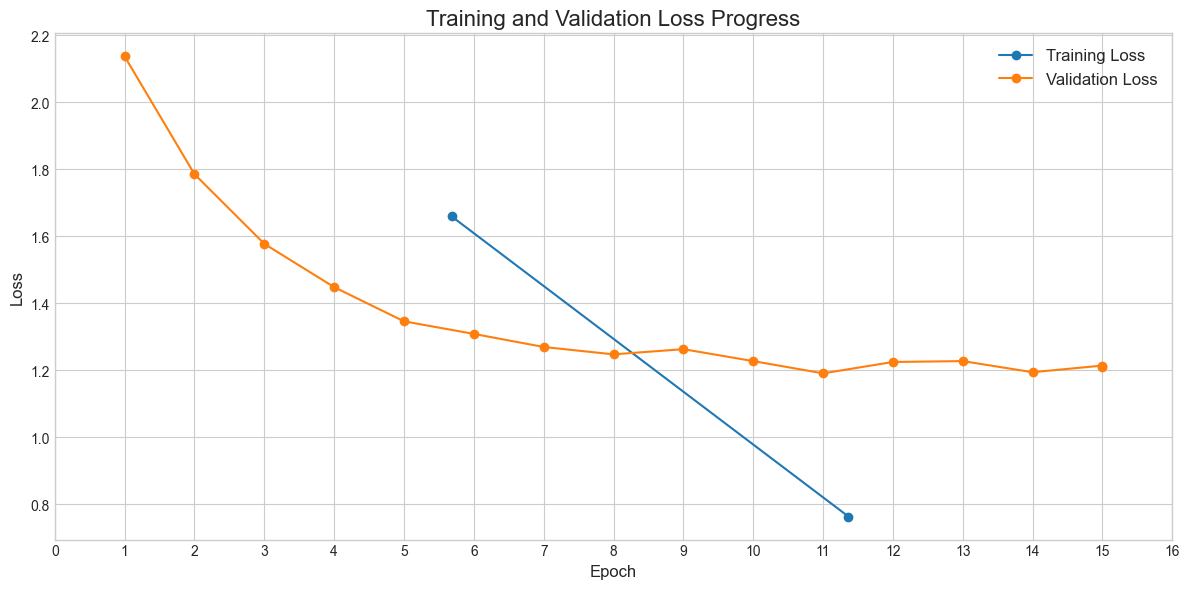

2025-08-13 21:07:39,325 [INFO] - Validation metrics plot saved as 'validation_metrics.png'


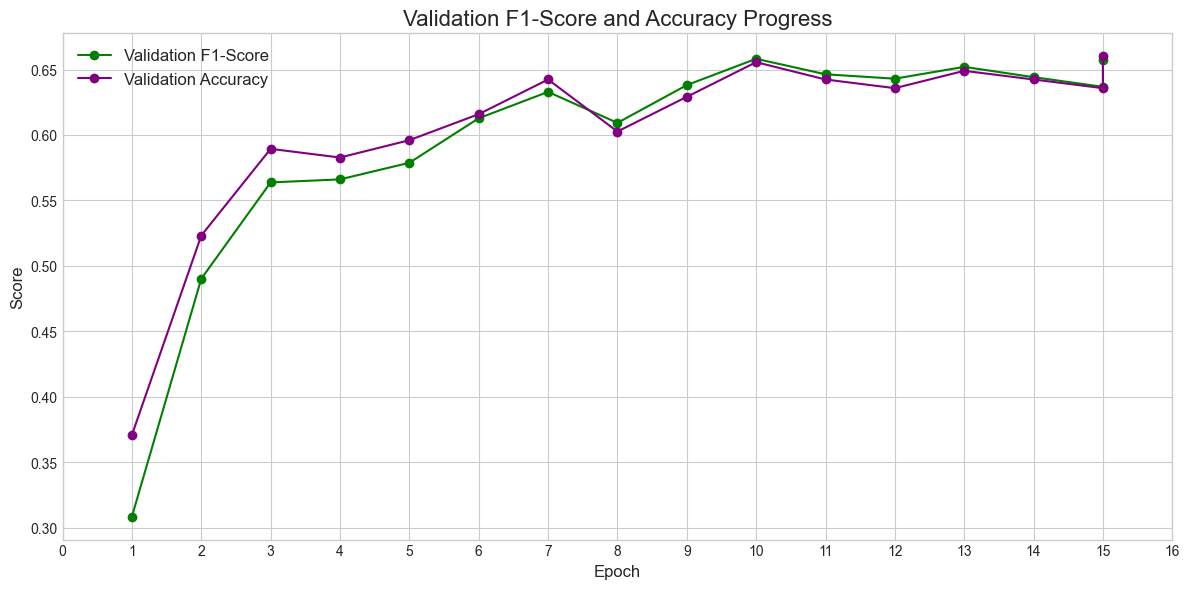

2025-08-13 21:07:39,403 [INFO] - Starting detailed evaluation on the test set...



--- Classification Report on the Test Set ---

                                          precision    recall  f1-score   support

                   Controllore e Isolata     0.7692    0.6667    0.7143        15
             Dominante e Schiavo emotivo     0.6667    0.4000    0.5000        15
           Geloso-Ossessivo e Sottomessa     0.7778    0.4667    0.5833        15
       Manipolatore e Dipendente emotiva     0.7857    0.7333    0.7586        15
                    Narcisista e Succube     0.5000    0.6000    0.5455        15
Perfezionista Critico e Insicura Cronica     0.6316    0.8000    0.7059        15
              Persona violenta e Succube     0.6000    0.6000    0.6000        15
                Psicopatico e Adulatrice     0.7500    0.8000    0.7742        15
             Sadico-Crudele e Masochista     0.5217    0.8000    0.6316        15
              Vittimista e Croccerossina     0.7857    0.7333    0.7586        15

                                accuracy        

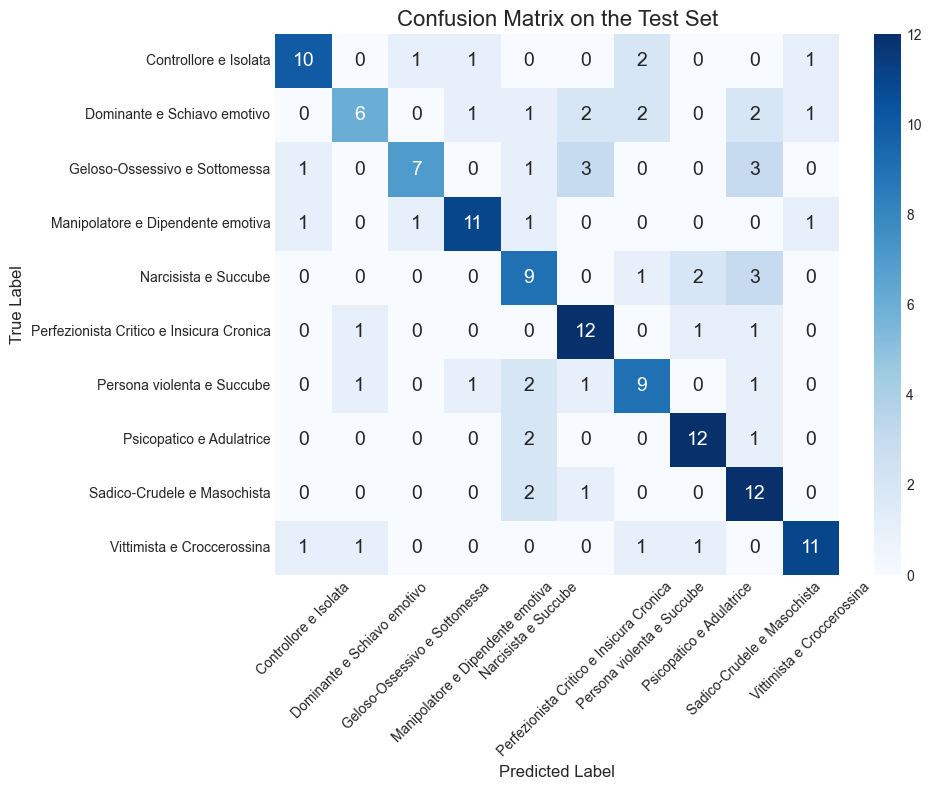

In [ ]:
logging.info("Creating training progress plots...")

# Extract the complete history from the trainer
log_history = trainer.state.log_history

# Filter to get only training and evaluation logs
train_history = [log for log in log_history if 'loss' in log and 'epoch' in log]
eval_history = [log for log in log_history if 'eval_loss' in log and 'epoch' in log]

# Convert to DataFrame for easier handling
train_df = pd.DataFrame(train_history)
eval_df = pd.DataFrame(eval_history)

# Merge data based on the epoch for proper alignment
if not train_df.empty and not eval_df.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 6))
    plt.plot(train_df['epoch'], train_df['loss'], 'o-', label='Training Loss')
    plt.plot(eval_df['epoch'], eval_df['eval_loss'], 'o-', label='Validation Loss')
    plt.title('Training and Validation Loss Progress', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.xticks(np.arange(0, int(eval_df['epoch'].max()) + 2, 1))
    plt.tight_layout()
    plt.savefig('training_validation_loss.png')
    logging.info("Loss plot saved as 'training_validation_loss.png'")
    plt.show()

    # Plot for Validation F1-Score and Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(eval_df['epoch'], eval_df['eval_f1'], 'o-', label='Validation F1-Score', color='green')
    plt.plot(eval_df['epoch'], eval_df['eval_accuracy'], 'o-', label='Validation Accuracy', color='purple')
    plt.title('Validation F1-Score and Accuracy Progress', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.legend(fontsize=12)
    plt.xticks(np.arange(0, int(eval_df['epoch'].max()) + 2, 1))
    plt.tight_layout()
    plt.savefig('validation_metrics.png')
    logging.info("Validation metrics plot saved as 'validation_metrics.png'")
    plt.show()
else:
    logging.warning("Insufficient log data to create progress plots.")


logging.info("Starting detailed evaluation on the test set...")

# Get predictions for the test set
test_predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = np.argmax(test_predictions.predictions, axis=-1)
true_labels = test_predictions.label_ids

# Retrieve class names from the id2label mapping
class_names = [id2label[i] for i in range(len(id2label))]

# Print and save the Classification Report
print("\n--- Classification Report on the Test Set ---\n")
report = classification_report(true_labels, predicted_labels, target_names=class_names, digits=4)
print(report)

report_path = 'classification_report.txt'
with open(report_path, "w") as f:
    f.write("--- Classification Report on the Test Set ---\n\n")
    f.write(report)
logging.info(f"Classification report saved in '{report_path}'")


# Generate, display, and save the Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 14})
plt.title('Confusion Matrix on the Test Set', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
confusion_matrix_path = 'confusion_matrix.png'
plt.savefig(confusion_matrix_path)
logging.info(f"Confusion matrix saved in '{confusion_matrix_path}'")
plt.show()
